In [1]:
from finn.util.basic import make_build_dir
from finn.util.visualization import showSrc, showInNetron
    
build_dir = "/workspace/finn/lenet"

MODEL_PREFIX = "test_model"
import onnx
from finn.util.test import get_test_model_trained
import brevitas.onnx as bo
from finn.core.modelwrapper import ModelWrapper
from finn.transformation.infer_shapes import InferShapes
from finn.transformation.fold_constants import FoldConstants
from finn.transformation.general import GiveReadableTensorNames, GiveUniqueNodeNames, RemoveStaticGraphInputs

In [2]:
import torch
from torch.nn import Module, ModuleList, BatchNorm2d, MaxPool2d, BatchNorm1d

from brevitas.nn import QuantConv2d, QuantIdentity, QuantLinear
from brevitas.core.restrict_val import RestrictValueType
from brevitas_examples.bnn_pynq.models.common import CommonWeightQuant, CommonActQuant
from brevitas.core.restrict_val import RestrictValueType
from brevitas_examples.bnn_pynq.models.tensor_norm import TensorNorm

In [3]:
from brevitas.core.scaling import ScalingImplType
from brevitas.core.stats import StatsOp
from brevitas.nn import QuantReLU
from brevitas.core.quant import QuantType


In [11]:
# CNV_OUT_CH_POOL = [(64, False), (64, True), (128, False), (128, True), (256, False), (256, False)]
CNV_OUT_CH_POOL = [(6, True), (16, True)]

INTERMEDIATE_FC_FEATURES = [(16*4*4, 120), (120, 84)]
LAST_FC_IN_FEATURES = 84

POOL_SIZE = 2
KERNEL_SIZE = 5

MAX_RELU_VAL = 6.0

class CNV(Module):

    def __init__(self, num_classes, weight_bit_width, act_bit_width, in_bit_width, in_ch=1):
        super(CNV, self).__init__()

        self.conv_features = ModuleList()
        self.linear_features = ModuleList()

        self.conv_features.append(QuantIdentity( # for Q1.7 input format
            act_quant=CommonActQuant,
            bit_width=in_bit_width,
            min_val=- 1.0,
            max_val=1.0 - 2.0 ** (-7),
            narrow_range=False,
            restrict_scaling_type=RestrictValueType.POWER_OF_TWO))

        for out_ch, is_pool_enabled in CNV_OUT_CH_POOL:
            self.conv_features.append(QuantConv2d(
                kernel_size=KERNEL_SIZE,
                in_channels=in_ch,
                out_channels=out_ch,
                bias=False,
                weight_quant=CommonWeightQuant,
                weight_bit_width=weight_bit_width))
            
            self.conv_features.append(QuantReLU(
                bit_width=act_bit_width,
                quant_type=QuantType.INT,
                weight_quant=CommonWeightQuant,
                max_val=MAX_RELU_VAL
            ))
            
            in_ch = out_ch
            self.conv_features.append(BatchNorm2d(in_ch, eps=1e-4))
            self.conv_features.append(QuantIdentity(
                act_quant=CommonActQuant,
                bit_width=act_bit_width))
            if is_pool_enabled:
                self.conv_features.append(MaxPool2d(kernel_size=2))

        for in_features, out_features in INTERMEDIATE_FC_FEATURES:
            self.linear_features.append(QuantLinear(
                in_features=in_features,
                out_features=out_features,
                bias=False,
                weight_quant=CommonWeightQuant,
                weight_bit_width=weight_bit_width))
            
            self.linear_features.append(QuantReLU(
                bit_width=act_bit_width,
                quant_type=QuantType.INT,
                weight_quant=CommonWeightQuant,
                max_val=MAX_RELU_VAL
            ))
            
            self.linear_features.append(BatchNorm1d(out_features, eps=1e-4))
            self.linear_features.append(QuantIdentity(
                act_quant=CommonActQuant,
                bit_width=act_bit_width))

        self.linear_features.append(QuantLinear(
            in_features=LAST_FC_IN_FEATURES,
            out_features=num_classes,
            bias=False,
            weight_quant=CommonWeightQuant,
            weight_bit_width=weight_bit_width))
        
        self.linear_features.append(QuantReLU(
            bit_width=act_bit_width,
            quant_type=QuantType.INT,
            weight_quant=CommonWeightQuant,
            max_val=MAX_RELU_VAL,
#             scaling_impl_type=ScalingImplType.CONST,
#             scaling_stats_permute_dims=None,
#             scaling_stats_op=StatsOp.MAX
        ))
        
        self.linear_features.append(TensorNorm())
        
        for m in self.modules():
            if isinstance(m, QuantConv2d) or isinstance(m, QuantLinear):
                torch.nn.init.uniform_(m.weight.data, -1, 1)


    def clip_weights(self, min_val, max_val):
        for mod in self.conv_features:
            if isinstance(mod, QuantConv2d):
                mod.weight.data.clamp_(min_val, max_val)
        for mod in self.linear_features:
            if isinstance(mod, QuantLinear):
                mod.weight.data.clamp_(min_val, max_val)

    def forward(self, x):
        x = 2.0 * x - torch.tensor([1.0], device=x.device)
        for mod in self.conv_features:
            x = mod(x)
        x = x.view(x.shape[0], -1)
        for mod in self.linear_features:
            x = mod(x)
        return x


def cnv(weight_bit_width, act_bit_width, in_bit_width, num_classes, in_channels):
#     weight_bit_width = cfg.getint('QUANT', 'WEIGHT_BIT_WIDTH')
#     act_bit_width = cfg.getint('QUANT', 'ACT_BIT_WIDTH')
#     in_bit_width = cfg.getint('QUANT', 'IN_BIT_WIDTH')
#     num_classes = cfg.getint('MODEL', 'NUM_CLASSES')
#     in_channels = cfg.getint('MODEL', 'IN_CHANNELS')
    net = CNV(weight_bit_width=weight_bit_width,
              act_bit_width=act_bit_width,
              in_bit_width=in_bit_width,
              num_classes=num_classes,
              in_ch=in_channels)
    return net

In [12]:
from torch.nn import Module
import torch.nn.functional as F
from brevitas.nn import QuantIdentity, QuantConv2d, QuantReLU
from brevitas.core.quant import QuantType

class QuantLeNet(Module):
    def __init__(self):
        super(QuantLeNet, self).__init__()
        self.quant_inp = QuantIdentity(bit_width=8, min_val=-1.0, max_val=1.0)
        self.conv1 = QuantConv2d(1, 6, 5, weight_bit_width=4)
        self.relu1 = QuantReLU(bit_width=8, max_val=6)
        self.conv2 = QuantConv2d(6, 16, 5, weight_bit_width=4)
        self.relu2 = QuantReLU(bit_width=4, max_val=6)
        self.fc1   = QuantLinear(16*4*4, 120, bias=True, weight_bit_width=4)
        self.relu3 = QuantReLU(bit_width=8, max_val=6)
        self.fc2   = QuantLinear(120, 84, bias=True, weight_bit_width=4)
        self.relu4 = QuantReLU(bit_width=8, max_val=6)
        self.fc3   = QuantLinear(84, 10, bias=False, weight_bit_width=4)

    def forward(self, x):
        out = self.quant_inp(x)
        out = self.relu1(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = self.relu2(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.relu3(self.fc1(out))
        out = self.relu4(self.fc2(out))
        out = self.fc3(out)
        return out

In [13]:
# model = cnv(4, 8, 8, 10, 1)
model = QuantLeNet()

In [14]:
# [x for x in dir(model.conv_features[0]) if 'ame' in x]

In [15]:
# [x._get_name() for x in model.conv_features]

In [16]:
# [x._get_name() for x in model.linear_features]

In [17]:
bo.export_finn_onnx(model, (1, 1, 28, 28), build_dir + f"/{MODEL_PREFIX}_export.onnx")
model = ModelWrapper(build_dir + f"/{MODEL_PREFIX}_export.onnx")

In [18]:
model = model.transform(InferShapes())

In [19]:
model = model.transform(FoldConstants())


In [20]:
model = model.transform(GiveUniqueNodeNames())


In [21]:
model = model.transform(GiveReadableTensorNames())


In [22]:
model = model.transform(RemoveStaticGraphInputs())


In [23]:
model.save(build_dir + f"/{MODEL_PREFIX}_tidy.onnx")
showInNetron(build_dir+f"/{MODEL_PREFIX}_tidy.onnx")

Serving '/workspace/finn/lenet/test_model_tidy.onnx' at http://0.0.0.0:8081


In [24]:
from finn.util.pytorch import ToTensor
from finn.transformation.merge_onnx_models import MergeONNXModels
from finn.core.datatype import DataType

model = ModelWrapper(build_dir+f"/{MODEL_PREFIX}_tidy.onnx")
global_inp_name = model.graph.input[0].name
ishape = model.get_tensor_shape(global_inp_name)

# preprocessing: torchvision's ToTensor divides uint8 inputs by 255
totensor_pyt = ToTensor()
chkpt_preproc_name = build_dir+f"/{MODEL_PREFIX}_preproc.onnx"
bo.export_finn_onnx(totensor_pyt, ishape, chkpt_preproc_name)

# join preprocessing and core model
pre_model = ModelWrapper(chkpt_preproc_name)
model = model.transform(MergeONNXModels(pre_model))

# add input quantization annotation: UINT8 for all BNN-PYNQ models
global_inp_name = model.graph.input[0].name
model.set_tensor_datatype(global_inp_name, DataType.UINT8)

/workspace/finn/src/finn/transformation/infer_data_layouts.py:113: UserWarning: Assuming 4D input is NCHW
  warnings.warn("Assuming 4D input is NCHW")


In [25]:
from finn.transformation.insert_topk import InsertTopK
from finn.transformation.infer_datatypes import InferDataTypes

# postprocessing: insert Top-1 node at the end
model = model.transform(InsertTopK(k=1))
chkpt_name = build_dir+"/end2end_cnv_w1a1_pre_post.onnx"
# tidy-up again
model = model.transform(InferShapes())
model = model.transform(FoldConstants())
model = model.transform(GiveUniqueNodeNames())
model = model.transform(GiveReadableTensorNames())
model = model.transform(InferDataTypes())
model = model.transform(RemoveStaticGraphInputs())
model.save(chkpt_name)

showInNetron(build_dir+"/end2end_cnv_w1a1_pre_post.onnx")


Stopping http://0.0.0.0:8081
Serving '/workspace/finn/lenet/end2end_cnv_w1a1_pre_post.onnx' at http://0.0.0.0:8081


In [26]:
from finn.transformation.streamline import Streamline
from finn.transformation.lower_convs_to_matmul import LowerConvsToMatMul
from finn.transformation.bipolar_to_xnor import ConvertBipolarMatMulToXnorPopcount
import finn.transformation.streamline.absorb as absorb
from finn.transformation.streamline.reorder import MakeMaxPoolNHWC, MoveScalarLinearPastInvariants
from finn.transformation.infer_data_layouts import InferDataLayouts
from finn.transformation.general import RemoveUnusedTensors

model = ModelWrapper(build_dir + "/end2end_cnv_w1a1_pre_post.onnx")
model = model.transform(MoveScalarLinearPastInvariants())
model = model.transform(Streamline())
model = model.transform(LowerConvsToMatMul())
model = model.transform(MakeMaxPoolNHWC())
model = model.transform(absorb.AbsorbTransposeIntoMultiThreshold())
model = model.transform(ConvertBipolarMatMulToXnorPopcount())
model = model.transform(Streamline())
# absorb final add-mul nodes into TopK
model = model.transform(absorb.AbsorbScalarMulAddIntoTopK())
model = model.transform(InferDataLayouts())
model = model.transform(RemoveUnusedTensors())
model.save(build_dir + "/end2end_cnv_w1a1_streamlined.onnx")

In [27]:
showInNetron(build_dir+"/end2end_cnv_w1a1_streamlined.onnx")


Stopping http://0.0.0.0:8081
Serving '/workspace/finn/lenet/end2end_cnv_w1a1_streamlined.onnx' at http://0.0.0.0:8081


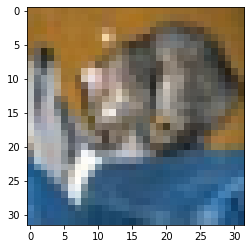

In [38]:
# import pkg_resources as pk
# import matplotlib.pyplot as plt
# import numpy as np

# fn = pk.resource_filename("finn", "data/cifar10/cifar10-test-data-class3.npz")
# x = np.load(fn)["arr_0"]
# x = x.reshape(3, 32,32).transpose(1, 2, 0)
# plt.imshow(x)

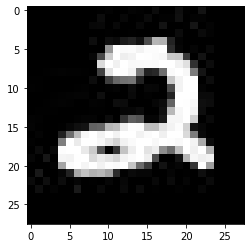

In [40]:
from pkgutil import get_data
import onnx.numpy_helper as nph
import matplotlib.pyplot as plt

raw_i = get_data("finn", "data/onnx/mnist-conv/test_data_set_0/input_0.pb")
x = nph.to_array(onnx.load_tensor_from_string(raw_i))
plt.imshow(x.reshape(28,28), cmap='gray')

In [41]:
model = ModelWrapper(build_dir + "/end2end_cnv_w1a1_streamlined.onnx")
iname = model.graph.input[0].name
ishape = model.get_tensor_shape(iname)
print("Expected network input shape is " + str(ishape))

import numpy as np
import bitstring
from finn.core.onnx_exec import execute_onnx

input_dict = {iname: x.reshape(ishape)}
ret = execute_onnx(model, input_dict)

Expected network input shape is [1, 1, 28, 28]


In [42]:
ret

{'global_out': array([[1]], dtype=int64)}